In [1]:
import numpy as np
import tensorflow  as tf
import matplotlib.pyplot as plt
import os
import torch
from matplotlib import cm
import tqdm

In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
def plot_acc(history):

    # Accuracy
    plt.figure()
    plt.plot(
        history.history['accuracy'],
        label='Accuracy',
        marker='o',
        color = 'green'
    )
    plt.plot(
        history.history['val_accuracy'],
        label='Validation Accuracy',
        marker='o',
        color = 'red'
    )
    plt.title('Accuracy of model on each data')
    plt.xlabel('Epochs')
    plt.ylabel('%',rotation=0)
    plt.legend()
    plt.grid()

    # Loss
    plt.figure()
    plt.plot(
        history.history['loss'],
        label='Loss',
        marker='o',
        color = 'green'
    )
    plt.plot(
        history.history['val_loss'],
        label='Validation Loss',
        marker='o',
        color = 'red'
    )
    plt.title('Loss of model on each data')
    plt.xlabel('Epochs')
    plt.legend()
    plt.grid()


## TensorFlow

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path='mnist.npz')

11490434/11490434 [==============================] - 0s 0us/step


In [5]:
print(f'There is total {x_train.shape[0]} images for train and {x_test.shape[0]} for test',end='\n\n')
print(f'The size of each image is {x_train.shape[1:]} for both train and test input data', end='\n\n')
print(f'Train output has  the shape of {y_train.shape} and the test output has the shape of {y_test.shape}')

There is total 60000 images for train and 10000 for test

The size of each image is (28, 28) for both train and test input data

Train output has  the shape of (60000,) and the test output has the shape of (10000,)


Displaying an example of each class

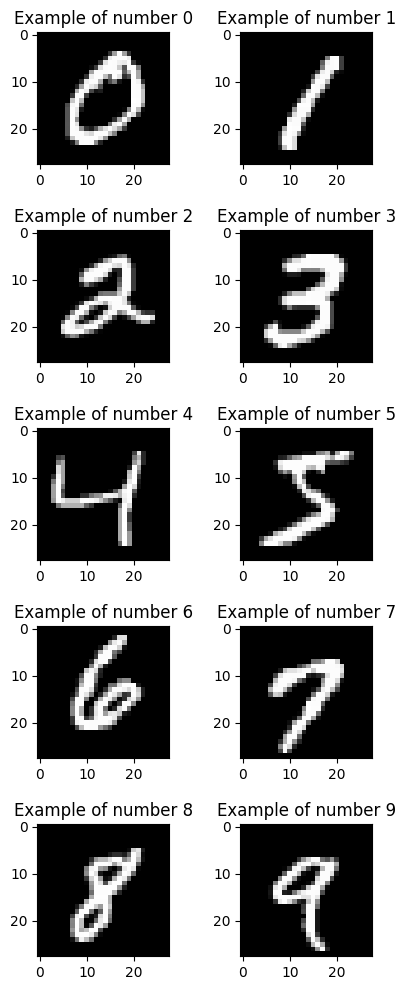

In [6]:
plt.figure(figsize=(5,12))
for i in range(10):

    image = x_train[y_train==i][0]
    plt.subplot(5,2,i+1)
    plt.imshow(image,cmap='gray')
    plt.title(f'Example of number {i}')
    plt.subplots_adjust(hspace=0.5, wspace=0.1)


Plotting the histogram

Text(0.5, 0, 'Classes')

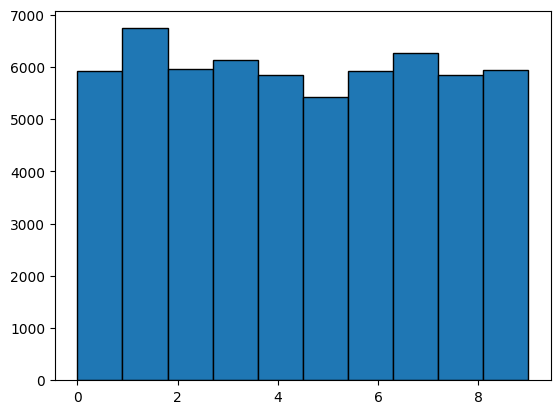

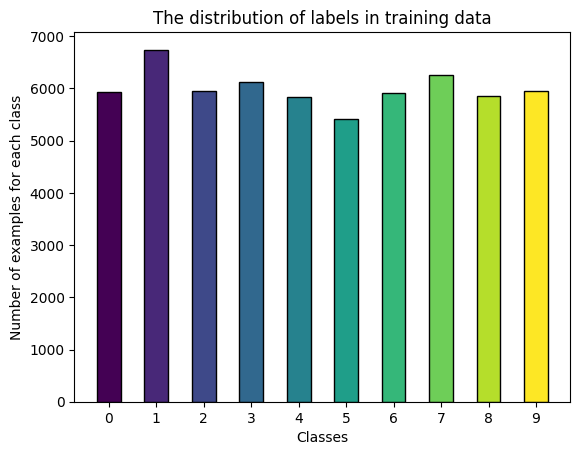

In [7]:
hist, bins = np.histogram(y_train,bins=10)
cmap = cm.get_cmap('viridis')

# With histogram
plt.figure()
plt.hist(y_train,bins=bins,edgecolor='black')

# With barplot
plt.figure()
bins = np.arange(0,10,1) # This is to correct the bins
plt.bar(bins, hist, width=0.5,edgecolor='black',color=cmap(np.linspace(0, 1, len(hist))))
plt.xticks(range(len(hist)), range(10))
plt.title('The distribution of labels in training data')
plt.ylabel('Number of examples for each class')
plt.xlabel('Classes')

Normalizing the data

In [8]:
from sklearn.preprocessing import MinMaxScaler

# Scaling the data (The shape must be adjusted for the MinMaxScaler to work)
scaler = MinMaxScaler()
scaler.fit(x_train.reshape(-1,28*28)) # Creaing the parameters
x_train_scaled = scaler.fit_transform(x_train.reshape(-1,28*28))
x_test_scaled = scaler.fit_transform(x_test.reshape(-1,28*28))

# Reshaping the scaled data to the original form
x_train_scaled = x_train_scaled.reshape(-1,28,28)
x_test_scaled = x_test_scaled.reshape(-1,28,28)

# Printing the difference
print(f'The max of "x_train" is {np.max(x_train)} and the max of "x_train_scaled" is {np.max(x_train_scaled)}',end='\n\n')
print(f'The max of "x_test" is {np.max(x_test)} and the max of "x_test_scaled" is {np.max(x_test_scaled)}',end='\n\n')

The max of "x_train" is 255 and the max of "x_train_scaled" is 1.0

The max of "x_test" is 255 and the max of "x_test_scaled" is 1.0



### Teacher's network

Creating the model

In [5]:
from tensorflow.keras.layers import Input, Dense, Activation, Flatten
from tensorflow.keras.models import Model

In [9]:
teacher = tf.keras.models.Sequential(
    [
        Input(shape=(28,28,)),
        Flatten(),
        Dense(1024,activation='relu'),
        Dense(512, activation='relu'),
        Dense(10, activation='linear')
    ]
    )
teacher.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 1024)              803840    
                                                                 
 dense_4 (Dense)             (None, 512)               524800    
                                                                 
 dense_5 (Dense)             (None, 10)                5130      
                                                                 
Total params: 1333770 (5.09 MB)
Trainable params: 1333770 (5.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Training the model


In the context of machine learning, particularly in neural networks and deep learning, the term "**logits**" refers to the *raw*, *unnormalized predictions* generated by a model **before applying an activation function or a probability distribution.**

In [10]:
teacher.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),# Because there was no softmax we should set the from_logits  to True
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics = 'accuracy'
    )

t_history = teacher.fit(
    x = x_train_scaled,
    y = y_train,
    epochs =20,
    batch_size = 32,
    validation_data = (x_test_scaled,y_test)
    )

Epoch 1/20
1875/1875 [==============================] - 31s 16ms/step - loss: 0.5237 - accuracy: 0.8694 - val_loss: 0.2775 - val_accuracy: 0.9238
Epoch 2/20
1875/1875 [==============================] - 28s 15ms/step - loss: 0.2585 - accuracy: 0.9266 - val_loss: 0.2284 - val_accuracy: 0.9322
Epoch 3/20
1875/1875 [==============================] - 30s 16ms/step - loss: 0.2090 - accuracy: 0.9409 - val_loss: 0.1857 - val_accuracy: 0.9467
Epoch 4/20
1875/1875 [==============================] - 30s 16ms/step - loss: 0.1755 - accuracy: 0.9507 - val_loss: 0.1593 - val_accuracy: 0.9538
Epoch 5/20
1875/1875 [==============================] - 29s 15ms/step - loss: 0.1513 - accuracy: 0.9569 - val_loss: 0.1437 - val_accuracy: 0.9583
Epoch 6/20
1875/1875 [==============================] - 30s 16ms/step - loss: 0.1329 - accuracy: 0.9628 - val_loss: 0.1269 - val_accuracy: 0.9632
Epoch 7/20
1875/1875 [==============================] - 31s 16ms/step - loss: 0.1176 - accuracy: 0.9679 - val_loss: 0.1176 -

Plotting the accuracy of the model for each epoch

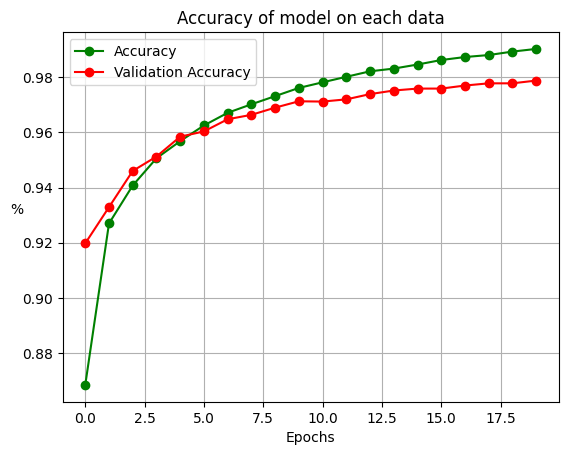

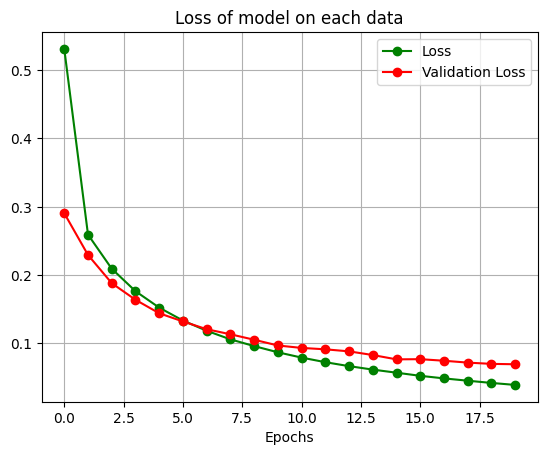

In [ ]:
plot_acc(t_history)

In [ ]:
y_test_hat = teacher.predict(x_test_scaled)

313/313 [==============================] - 1s 2ms/step


In [ ]:
y_test_hat_arg = np.argmax(y_test_hat,axis=1)
miss_class_test = np.sum(np.array(y_test_hat_arg != y_test))
print(f'There are {miss_class_test} miscalssified test examples from total of {len(y_test)} test examples')

There are 213 miscalssified test examples from total of 10000 test examples


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_hat_arg))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.97      0.98       982
           5       0.98      0.97      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.97      0.97      0.97       974
           9       0.96      0.98      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



### Student's network

In [17]:
import tensorflow as tf

inputs = tf.keras.Input(shape=(28, 28))
x = tf.keras.layers.Flatten()(inputs)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
student_logits = tf.keras.layers.Dense(10, activation='relu')(x)

student = tf.keras.Model(inputs=inputs, outputs=student_logits, name='student')

student.summary()
student_2 = tf.keras.models.clone_model(student)

Model: "student"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_12 (Dense)            (None, 128)               100480    
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 10)                650       
                                                                 
Total params: 109386 (427.29 KB)
Trainable params: 109386 (427.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
student.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),# Because there was no softmax we should set the from_logits  to True
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics = 'accuracy'
)

In [19]:
s_history = student.fit(
    x = x_train_scaled,
    y = y_train,
    epochs = 10,
    batch_size = 32,
    validation_data = (x_test_scaled, y_test)
)

Epoch 1/10
1875/1875 [==============================] - 13s 7ms/step - loss: 1.0877 - accuracy: 0.6712 - val_loss: 0.7703 - val_accuracy: 0.7417
Epoch 2/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.7487 - accuracy: 0.7405 - val_loss: 0.6972 - val_accuracy: 0.7522
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.6805 - accuracy: 0.7603 - val_loss: 0.5070 - val_accuracy: 0.8390
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4610 - accuracy: 0.8477 - val_loss: 0.4320 - val_accuracy: 0.8525
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4180 - accuracy: 0.8573 - val_loss: 0.4052 - val_accuracy: 0.8586
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3939 - accuracy: 0.8627 - val_loss: 0.3899 - val_accuracy: 0.8628
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3765 - accuracy: 0.8674 - val_loss: 0.3758 - val_accurac

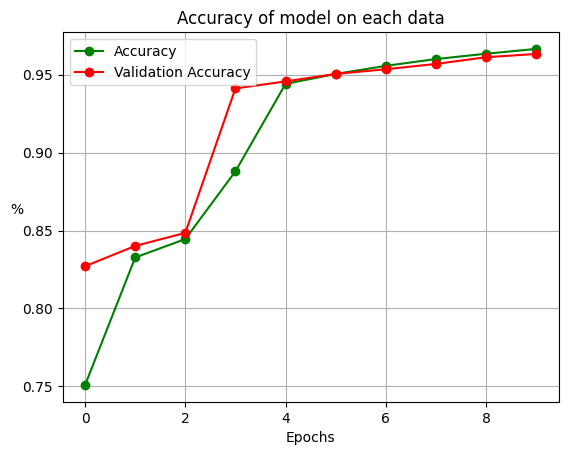

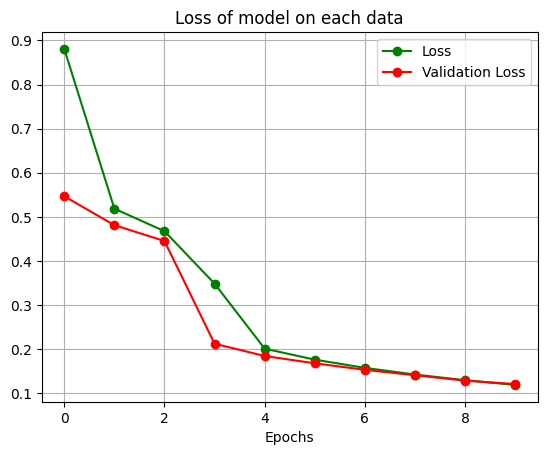

In [ ]:
plot_acc(s_history)

### Knowledge Distillation

In [ ]:
t_logits_train = teacher.predict(x_train_scaled)
t_logits_test = teacher.predict(x_test_scaled)

313/313 [==============================] - 0s 2ms/step


In [25]:
class Distiller(tf.keras.Model):

    def __init__(self,student, teacher):
        super(Distiller,self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
            self,
            optimizer,
            metrics,
            student_loss_fnc,
            dis_loss_fnc,
            alpha = 0.5,
            temperature = 3
    ):
        super(Distiller,self).compile(
            optimizer=optimizer,
            metrics=metrics
        )
        self.student_loss_fnc = student_loss_fnc
        self.dis_loss_fnc = dis_loss_fnc
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self,data):
        x,y = data
        # Teacher model logits
        teacher_logit = self.teacher(x,training=False)
        # GradientTape records operations and we can use this recordings to
        # Calculate gradients later
        with tf.GradientTape() as tape:
            # Student model logits
            student_logit = self.student(x,training=True)
            # Student Loss
            student_loss = self.student_loss_fnc(y,student_logit)
            # Calculating arrays for Distillation loss
            dist1 = tf.nn.softmax(teacher_logit/self.temperature, axis=1)
            dist2 = tf.nn.softmax(student_logit/self.temperature, axis=1)
            # Distillation loss
            dis_loss = self.dis_loss_fnc(dist1,dist2)
            # Total loss
            loss = self.alpha*student_loss + dis_loss
        # Variables to be trained
        vars = self.student.trainable_variables
        # Calculating gradients
        grads = tape.gradient(loss, vars)
        # Optimizing weights
        self.optimizer.apply_gradients(zip(grads,vars))
        # Updating matrices
        self.compiled_metrics.update_state(y,student_logit)
        # updating result dict.
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {
                'student_loss':student_loss,
                'distillation_loss':dis_loss
            }
        )
        return results

    def test_step (self,data):

        x,y = data
        # Prediction
        y_hat = self.student(x,training=False)
        # Student loss
        student_loss = self.student_loss_fnc(y,y_hat)
        # Add student loss to reluts dict.
        self.compiled_metrics.update_state(y,y_hat)
        # Updating results dict.
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results




In [27]:
# Initialize and compile distiller
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=['acc'],
    student_loss_fnc=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    dis_loss_fnc=tf.keras.losses.KLDivergence(),
    alpha=0.5,
    temperature=2,
)

distiller_hist = distiller.fit(
    x = x_train_scaled,
    y = y_train,
    epochs =20,
    batch_size = 32,
    validation_data = (x_test_scaled,y_test)
    )

Epoch 1/20
1875/1875 [==============================] - 15s 7ms/step - acc: 0.9183 - student_loss: 0.2306 - distillation_loss: 0.1717 - val_acc: 0.9627 - val_student_loss: 0.0028
Epoch 2/20
1875/1875 [==============================] - 14s 7ms/step - acc: 0.9744 - student_loss: 0.0859 - distillation_loss: 0.0684 - val_acc: 0.9649 - val_student_loss: 0.0010
Epoch 3/20
1875/1875 [==============================] - 13s 7ms/step - acc: 0.9764 - student_loss: 0.0812 - distillation_loss: 0.0663 - val_acc: 0.9681 - val_student_loss: 0.0017
Epoch 4/20
1875/1875 [==============================] - 14s 7ms/step - acc: 0.9776 - student_loss: 0.0753 - distillation_loss: 0.0630 - val_acc: 0.9703 - val_student_loss: 6.0339e-04
Epoch 5/20
1875/1875 [==============================] - 13s 7ms/step - acc: 0.9797 - student_loss: 0.0681 - distillation_loss: 0.0600 - val_acc: 0.9676 - val_student_loss: 0.0041
Epoch 6/20
1875/1875 [==============================] - 13s 7ms/step - acc: 0.9803 - student_loss: 0.

In [35]:
y_test_hat = student.predict(x_test_scaled)

313/313 [==============================] - 1s 3ms/step


In [36]:
y_test_hat_arg = np.argmax(y_test_hat,axis=1)
miss_class_test = np.sum(np.array(y_test_hat_arg != y_test))
print(f'There are {miss_class_test} miscalssified test examples from total of {len(y_test)} test examples')

There are 274 miscalssified test examples from total of 10000 test examples


In [37]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_hat_arg))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.98      0.99      0.98      1135
           2       0.98      0.96      0.97      1032
           3       0.95      0.98      0.96      1010
           4       0.97      0.98      0.97       982
           5       0.97      0.96      0.97       892
           6       0.97      0.98      0.98       958
           7       0.98      0.96      0.97      1028
           8       0.98      0.95      0.96       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



## Pytorch

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [5]:
# Path of folders
mnist_dir = '/content/MNIST'
train_dir = os.path.join(mnist_dir,'train')
test_dir = os.path.join(mnist_dir,'test')

# making paths
if not os.path.isdir(mnist_dir):
    os.makedirs(train_dir)
    os.mkdir(test_dir)

# Setting transforms to the data
data_transforms = transforms.Compose(
        [
        transforms.ToTensor(),      # Transform the data to tensor
        transforms.Normalize((0.5,),(0.5,)),     # Normalizing the data
        ]
    )

# Download data
mnist_train = datasets.MNIST(root=train_dir, train=True, download=True, transform=data_transforms)
mnist_test = datasets.MNIST(root=test_dir, train=False, download=True, transform=data_transforms)

# Load data on the system
batch_size = 32
train_data = torch.utils.data.DataLoader(mnist_train, batch_size = batch_size, shuffle=True)
test_data = torch.utils.data.DataLoader(mnist_test, shuffle=True)

# shape of the data
train_example = iter(train_data)
train_example, train_target = next(train_example)
print(f'The shape of the training data is {train_example.shape}')
print(f'The target of the chosen example is {train_target}', end='\n\n')

test_example = iter(test_data)
test_example, test_target = next(test_example)
print(f'The shape of the test data is {test_example.shape}')
print(f'The target of the test example is {test_target}')


100%|██████████| 9912422/9912422 [00:00<00:00, 248452012.05it/s]

Extracting /content/MNIST/train/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/train/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 15715580.41it/s]


Extracting /content/MNIST/train/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/train/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 123929601.23it/s]

Extracting /content/MNIST/train/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/train/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 16158209.30it/s]


Extracting /content/MNIST/train/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/train/MNIST/raw



100%|██████████| 9912422/9912422 [00:00<00:00, 148846166.56it/s]


Extracting /content/MNIST/test/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/test/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 86156254.50it/s]


Extracting /content/MNIST/test/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/test/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 112680712.28it/s]


Extracting /content/MNIST/test/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/test/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17754453.65it/s]


Extracting /content/MNIST/test/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/test/MNIST/raw

The shape of the training data is torch.Size([32, 1, 28, 28])
The target of the chosen example is tensor([4, 2, 0, 4, 7, 6, 7, 4, 6, 0, 7, 4, 3, 9, 8, 8, 2, 1, 9, 4, 4, 9, 2, 9,
        8, 2, 6, 4, 7, 7, 5, 0])

The shape of the test data is torch.Size([1, 1, 28, 28])
The target of the test example is tensor([6])


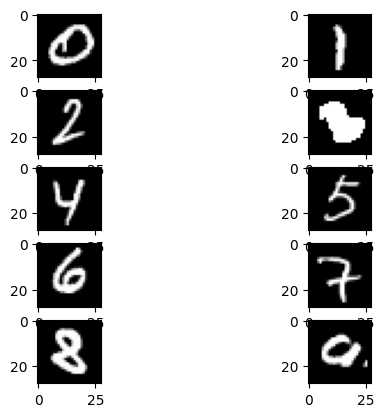

In [8]:
for i in range(10):

    plt.subplot(5,2,i+1)
    image = train_example[train_target==i][0]
    image = image.view(28,28).detach().numpy()
    plt.imshow(image,cmap='gray')

In [9]:
class_counts = torch.zeros(10)
for data in mnist_train:
    _, label = data
    class_counts[label] += 1

<BarContainer object of 10 artists>

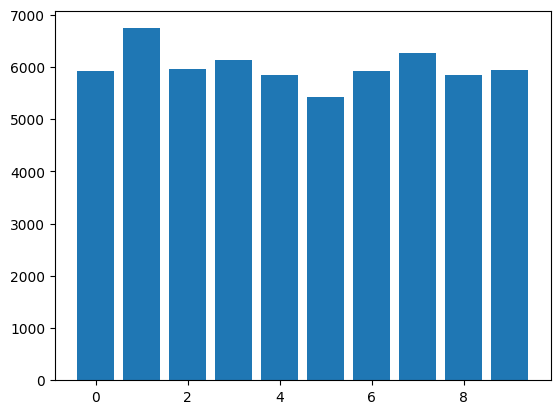

In [ ]:
classes = list(range(10))
plt.bar(classes, class_counts)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### Teacher

In [7]:
class Teacher(nn.Module):
    def __init__(self):
        super(Teacher,self).__init__()
        self.layer1 = nn.Linear(28*28,1024)
        self.layer2 = nn.Linear(1024,512)
        self.layer3 = nn.Linear(512,10)

    def forward(self,x):
        x = x.view(-1,28*28)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [8]:
teacher_model = Teacher().to(device)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(teacher_model.parameters(), lr=0.01)

In [37]:
epochs = 20
Loss = []
for epoch in range(epochs):

    # data = iter(train_data)
    for input,target in tqdm.tqdm(train_data):

        input, target = input.to(device), target.to(device)
        optimizer.zero_grad()
        yhat = teacher_model(input)
        loss = criterion(yhat,target)
        loss.backward()
        optimizer.step()
    Loss.append(loss)

100%|██████████| 1875/1875 [00:15<00:00, 122.04it/s]


### Student

In [19]:
class Student(nn.Module):
    def __init__(self):
        super(Student,self).__init__()
        self.layer1 = nn.Linear(28*28,128)
        self.layer2 = nn.Linear(128,16)
        self.layer3 = nn.Linear(16,10)

    def forward(self,x):
        x = x.view(-1,28*28)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [20]:
student_model = Student().to(device)

### Knowledge distillation

In [21]:
learning_rate = 0.001
epochs = 10
Temp = 3
soft_weight = 0.5
student_weight = soft_weight

In [34]:
ce_loss_fn = nn.CrossEntropyLoss()
dist_loss_fn = nn.KLDivLoss(reduction="batchmean")
optimizer = optim.Adam(student_model.parameters(),lr=learning_rate)

teacher_model.eval()
student_model.train()

for epoch in range(epochs):

    data = iter(train_data)
    running_loss = 0.0
    for _ in tqdm.trange(len(train_data)):

        inputs, labels = next(data)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.no_grad():
            teacher_logits = teacher_model(inputs)

        student_logits = student_model(inputs)

        soft_targets = F.softmax(teacher_logits/Temp, dim=-1)
        soft_prob = F.softmax(student_logits/Temp, dim=-1)

        dist_loss = dist_loss_fn(soft_targets,soft_prob)
        ce_loss = ce_loss_fn(student_logits,labels)

        loss = soft_weight*dist_loss + student_weight*ce_loss

        loss.backward()
        optimizer.step()

        running_loss +=  loss.item()

100%|██████████| 1875/1875 [00:18<00:00, 102.71it/s]


In [32]:
def test (model, test_data, device):

    model.to(device)
    model.eval()

    correct = 0
    total = 0

    data  = iter(test_data)
    with torch.no_grad():

        for _ in tqdm.trange(len(test_data)):
            inputs, labels = next(data)
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100*correct/total

    return acc

In [33]:
test(student_model, test_data, device)

100%|██████████| 10000/10000 [00:09<00:00, 1033.57it/s]


97.08